In [2]:
import pandas as pd

df = pd.read_csv("news_with_finbert.csv", on_bad_lines='skip')
df['news_date'] = pd.to_datetime(df['news_date'])
df.sort_values(['Stock_symbol', 'news_date'], inplace=True)

daily = (
    df.groupby(['Stock_symbol', 'news_date'])
      .agg({
          'sent_finbert': 'mean',
          'Close': 'last'
      })
      .reset_index()
)

daily['return'] = daily.groupby('Stock_symbol')['Close'].pct_change()
daily['next_day_return'] = daily.groupby('Stock_symbol')['return'].shift(-1)

daily.dropna(inplace=True)

corrs = (
    daily.groupby('Stock_symbol')[['sent_finbert', 'next_day_return']]
    .corr().iloc[0::2, -1].reset_index()
)
corrs.columns = ['Stock_symbol', 'drop', 'correlation']
corrs = corrs[['Stock_symbol', 'correlation']]
print("📈 Correlation between sentiment and next-day returns:")
print(corrs)

📈 Correlation between sentiment and next-day returns:
  Stock_symbol  correlation
0         AAPL    -0.060320
1         AMZN    -0.028497
2         MSFT     0.043071


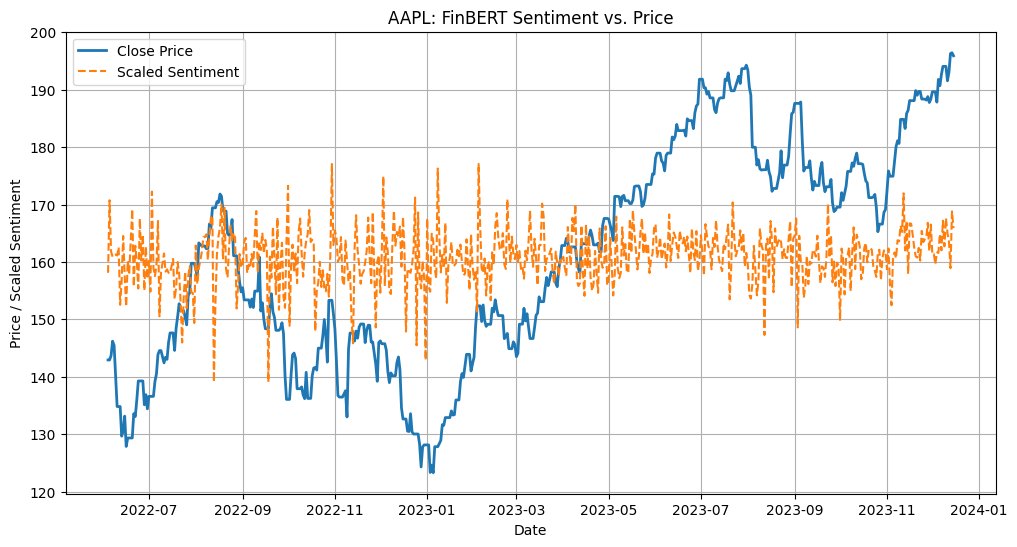

In [3]:
import matplotlib.pyplot as plt

ticker = "AAPL"
subset = daily[daily['Stock_symbol'] == ticker].copy()

scaled_sent = (subset['sent_finbert'] - subset['sent_finbert'].mean()) * subset['Close'].std() + subset['Close'].mean()

plt.figure(figsize=(12,6))
plt.plot(subset['news_date'], subset['Close'], label='Close Price', linewidth=2)
plt.plot(subset['news_date'], scaled_sent, label='Scaled Sentiment', linestyle='--')
plt.title(f"{ticker}: FinBERT Sentiment vs. Price")
plt.xlabel("Date")
plt.ylabel("Price / Scaled Sentiment")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd

sent = pd.read_csv("daily_sentiment.csv")
prices = pd.read_csv("news_with_finbert.csv")

sent = (
    sent.groupby(["news_date", "Stock_symbol"], as_index=False)
        .agg({"daily_sentiment": "mean"})
)

price_cols = ["Open", "High", "Low", "Close", "Volume"]
prices = (
    prices.groupby(["news_date", "Stock_symbol"], as_index=False)[price_cols].mean()
)

data = pd.merge(prices, sent, on=["news_date", "Stock_symbol"], how="inner")

data = data.sort_values(["Stock_symbol", "news_date"]).reset_index(drop=True)

data["return"] = data.groupby("Stock_symbol")["Close"].pct_change()
data["next_return"] = data.groupby("Stock_symbol")["return"].shift(-1)

#Create lagged sentiment features
data["sent_lag1"] = data.groupby("Stock_symbol")["daily_sentiment"].shift(1)
data["sent_lag2"] = data.groupby("Stock_symbol")["daily_sentiment"].shift(2)
data["sent_rolling3"] = data.groupby("Stock_symbol")["daily_sentiment"].transform(lambda x: x.rolling(3).mean())

data = data.dropna().reset_index(drop=True)

print("Cleaned dataset shape:", data.shape)
print(data.head(10))


✅ Cleaned dataset shape: (1417, 13)
    news_date Stock_symbol        Open        High         Low       Close  \
0  2022-06-05         AAPL  144.416534  145.468452  142.017796  142.922241   
1  2022-06-06         AAPL  144.544341  146.058315  142.450346  143.669388   
2  2022-06-07         AAPL  141.909677  146.481059  141.663903  146.195969   
3  2022-06-08         AAPL  146.068132  147.336317  144.967071  145.458618   
4  2022-06-09         AAPL  144.593534  145.448821  140.120451  140.228592   
5  2022-06-10         AAPL  137.908463  138.380344  134.742898  134.811722   
6  2022-06-11         AAPL  137.908463  138.380344  134.742898  134.811722   
7  2022-06-12         AAPL  137.908463  138.380344  134.742898  134.811722   
8  2022-06-13         AAPL  130.623736  132.914347  129.217918  129.650482   
9  2022-06-14         AAPL  130.879334  131.626480  129.257220  130.515579   

        Volume  daily_sentiment    return  next_return  sent_lag1  sent_lag2  \
0   88570300.0         0.

In [6]:
import pandas as pd
import numpy as np

CSV_PATH     = "model_input.csv"
WINDOW_SIZE  = 10  # number of past days the model sees
FEATURE_COLS = [
    "daily_sentiment", "sent_lag1", "sent_lag2", "sent_rolling3",
    "return", "Open", "High", "Low", "Close", "Volume"
]
TARGET_COL   = "next_return"

df = pd.read_csv(CSV_PATH)
# ensure proper types & ordering
df["news_date"] = pd.to_datetime(df["news_date"])
df = df.sort_values(["Stock_symbol", "news_date"]).reset_index(drop=True)

missing_feats = [c for c in FEATURE_COLS + [TARGET_COL, "Stock_symbol", "news_date"] if c not in df.columns]
if missing_feats:
    raise ValueError(f"Missing required columns in {CSV_PATH}: {missing_feats}")

df = df.dropna(subset=FEATURE_COLS + [TARGET_COL]).reset_index(drop=True)

X_list, y_list, meta = [], [], []  # meta keeps (ticker, end_date) for each sample

for ticker, g in df.groupby("Stock_symbol", sort=False):
    g = g.sort_values("news_date").reset_index(drop=True)
    values  = g[FEATURE_COLS].values.astype(np.float32)
    targets = g[TARGET_COL].values.astype(np.float32)
    dates   = g["news_date"].values

    if len(g) <= WINDOW_SIZE:
        continue  # not enough history for this ticker

    for i in range(WINDOW_SIZE, len(g)):
        X_list.append(values[i - WINDOW_SIZE:i])  # shape: (window, features)
        y_list.append(targets[i])                 # scalar: next-day return
        # store the label’s reference date (the day AFTER the window)
        meta.append((ticker, pd.Timestamp(dates[i]).date()))

X = np.stack(X_list) if X_list else np.empty((0, WINDOW_SIZE, len(FEATURE_COLS)), dtype=np.float32)
y = np.stack(y_list) if y_list else np.empty((0,), dtype=np.float32)

np.save("X_sequences.npy", X)
np.save("y_sequences.npy", y)

meta_df = pd.DataFrame(meta, columns=["Stock_symbol", "label_date"])
meta_df.to_csv("seq_meta.csv", index=False)

print("Sequences built.")
print(f"X shape: {X.shape}   (samples, window={WINDOW_SIZE}, features={len(FEATURE_COLS)})")
print(f"y shape: {y.shape}   (next-day return)")
print(f"Samples per ticker:\n{meta_df['Stock_symbol'].value_counts() if len(meta_df) else '—'}")

if len(X) > 0:
    print("\nFeature order:", FEATURE_COLS)
    print("Example window (first sample) shape:", X[0].shape)
    print("Example target (first sample):", float(y[0]))


Sequences built.
X shape: (21816, 10, 10)   (samples, window=10, features=10)
y shape: (21816,)   (next-day return)
Samples per ticker:
Stock_symbol
AAPL    8656
MSFT    8503
AMZN    4657
Name: count, dtype: int64

Feature order: ['daily_sentiment', 'sent_lag1', 'sent_lag2', 'sent_rolling3', 'return', 'Open', 'High', 'Low', 'Close', 'Volume']
Example window (first sample) shape: (10, 10)
Example target (first sample): 0.005227643996477127


In [8]:
# Trial 1: Transformer Encoder

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

X = np.load("X_sequences.npy")
y = np.load("y_sequences.npy")

print(f"Loaded sequences: X={X.shape}, y={y.shape}")

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False)

class TransformerRegressor(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, n_heads=5, n_layers=2, dropout=0.1, window_size=10):
        """
        feature_dim: number of features per day (10)
        n_heads: must divide feature_dim evenly (10 -> use 5)
        """
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim * window_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        x = self.transformer(x)
        return self.fc_out(x).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerRegressor(feature_dim=X.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f"Model initialized on {device}")
print(model)

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)

    model.eval()
    with torch.no_grad():
        preds_all, actual_all = [], []
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds = model(xb)
            preds_all.append(preds.cpu())
            actual_all.append(yb)
        preds_all = torch.cat(preds_all)
        actual_all = torch.cat(actual_all)
        test_loss = loss_fn(preds_all, actual_all).item()

    print(f"Epoch {epoch:02d}/{EPOCHS} | Train Loss={total_loss/len(train_dl.dataset):.6f} | Test Loss={test_loss:.6f}")

torch.save(model.state_dict(), "transformer_regressor.pt")
print("Transformer model trained and saved → transformer_regressor.pt")

np.save("test_preds.npy", preds_all.numpy())
np.save("test_actuals.npy", actual_all.numpy())
print("Saved test predictions and actuals → test_preds.npy, test_actuals.npy")


✅ Loaded sequences: X=(21816, 10, 10), y=(21816,)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


✅ Model initialized on cpu
TransformerRegressor(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
        )
        (linear1): Linear(in_features=10, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=10, bias=True)
        (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 01/20 | Train Loss=0.003687 | Test L

In [12]:
# Trial 2: Transformer encoder

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

CSV_PATH = "model_input.csv"
WINDOW = 10
FEATURES = ["daily_sentiment","sent_lag1","sent_lag2","sent_rolling3",
            "return","Open","High","Low","Close","Volume"]
TARGET   = "next_return"

EPOCHS   = 40
BATCH    = 128
LR       = 1e-3

df = pd.read_csv(CSV_PATH)
df["news_date"] = pd.to_datetime(df["news_date"])
df = df.sort_values(["Stock_symbol","news_date"]).reset_index(drop=True)

def zscore(s: pd.Series) -> pd.Series:
    m, sd = s.mean(), s.std(ddof=0)
    sd = sd if sd and np.isfinite(sd) else 1.0
    return (s - m) / sd

z_cols = []
for col in FEATURES:
    zcol = f"{col}_z"
    df[zcol] = df.groupby("Stock_symbol")[col].transform(zscore)
    z_cols.append(zcol)

# Target (scaled for training) + keep raw for evaluation
df["target_z"]   = df.groupby("Stock_symbol")[TARGET].transform(zscore)
df["target_raw"] = df[TARGET].astype(float)

# Drop any rows with NaNs created by shifts/rolling in FEATURES or TARGET
need_cols = [*FEATURES, *z_cols, "target_z", "target_raw", "Stock_symbol", "news_date"]
df = df.dropna(subset=need_cols).reset_index(drop=True)

# 3 Build sliding sequences (z-scored inputs)
X_list, y_z_list, y_raw_list = [], [], []

for ticker, g in df.groupby("Stock_symbol", sort=False):
    g = g.sort_values("news_date").reset_index(drop=True)
    Xg = g[z_cols].values.astype(np.float32)            # standardized features
    yg_z = g["target_z"].values.astype(np.float32)      # standardized target
    yg_raw = g["target_raw"].values.astype(np.float32)  # raw target

    if len(g) <= WINDOW:
        continue

    for i in range(WINDOW, len(g)):
        X_list.append(Xg[i-WINDOW:i])
        y_z_list.append(yg_z[i])
        y_raw_list.append(yg_raw[i])

X = np.stack(X_list) if X_list else np.empty((0, WINDOW, len(z_cols)), dtype=np.float32)
y_z = np.array(y_z_list, dtype=np.float32)
y_raw = np.array(y_raw_list, dtype=np.float32)

np.save("X_seq_z.npy", X)
np.save("y_seq_z.npy", y_z)
np.save("y_seq_raw.npy", y_raw)

print(f"Sequences built: X={X.shape}, y_z={y_z.shape}, y_raw={y_raw.shape}")


split = int(len(X) * 0.8)
X_tr, X_te = X[:split], X[split:]
y_tr_z, y_te_z = y_z[:split], y_z[split:]
y_tr_raw, y_te_raw = y_raw[:split], y_raw[split:]


feature_dim = X.shape[2]
def pick_heads(d):
    for h in [8,6,5,4,3,2,1]:
        if d % h == 0:
            return h
    return 1
N_HEADS = pick_heads(feature_dim)

class TransformerRegressor(nn.Module):
    def __init__(self, feature_dim, window, n_heads, hidden_dim=128, n_layers=3, dropout=0.1):
        super().__init__()
        enc_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=n_heads,
            dim_feedforward=hidden_dim, dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim*window, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerRegressor(feature_dim=feature_dim, window=WINDOW, n_heads=N_HEADS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

print(f"Model on {device} | feature_dim={feature_dim}, heads={N_HEADS}, window={WINDOW}")

def make_dl(Xa, ya, bs, shuffle):
    ds = TensorDataset(torch.tensor(Xa, dtype=torch.float32), torch.tensor(ya, dtype=torch.float32))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

from torch.utils.data import DataLoader
train_dl = make_dl(X_tr, y_tr_z, BATCH, True)
test_dl  = make_dl(X_te, y_te_z, BATCH, False)

for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * len(xb)

    model.eval()
    with torch.no_grad():
        preds_te = []
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds_te.append(model(xb).cpu())
        preds_te = torch.cat(preds_te).numpy()

    mse_te = mean_squared_error(y_te_z, preds_te)
    print(f"Epoch {ep:02d}/{EPOCHS} | Train MSE={total/len(X_tr):.6f} | Test MSE(z)={mse_te:.6f}")

torch.save(model.state_dict(), "transformer_regressor_z.pt")
print("Saved model → transformer_regressor_z.pt")

rmse_z = np.sqrt(mean_squared_error(y_te_z, preds_te))
mae_z  = mean_absolute_error(y_te_z, preds_te)
r2_z   = r2_score(y_te_z, preds_te)
corr_z = np.corrcoef(y_te_z, preds_te)[0,1]
dir_acc = float(np.mean((preds_te > 0) == (y_te_z > 0)))

pd.DataFrame([{
    "RMSE_z": rmse_z, "MAE_z": mae_z, "R2_z": r2_z, "Corr_z": corr_z,
    "Directional_Accuracy": dir_acc
}]).to_csv("metrics_scaled.csv", index=False)

print("\n=== Scaled-space metrics (z) ===")
print(f"RMSE_z={rmse_z:.4f} | MAE_z={mae_z:.4f} | R2_z={r2_z:.4f} | Corr_z={corr_z:.4f} | DirAcc={dir_acc*100:.2f}%")
print("Saved → metrics_scaled.csv")

# raw-space directional accuracy (same as z), plus raw RMSE/MAE by re-scaling is not
# possible per-ticker without storing each ticker's mean/std for the test slice.
dir_acc_raw = float(np.mean((preds_te > 0) == (y_te_raw[:len(preds_te)] > 0)))
pd.DataFrame([{"Directional_Accuracy_Raw": dir_acc_raw}]).to_csv("metrics_raw.csv", index=False)
print(f"\nRaw directional accuracy (using original returns sign): {dir_acc_raw*100:.2f}%")
print("Saved → metrics_raw.csv")


✅ Sequences built: X=(21816, 10, 10), y_z=(21816,), y_raw=(21816,)
✅ Model on cpu | feature_dim=10, heads=5, window=10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 01/40 | Train MSE=1.138169 | Test MSE(z)=0.490158
Epoch 02/40 | Train MSE=1.126697 | Test MSE(z)=0.487227
Epoch 03/40 | Train MSE=1.121678 | Test MSE(z)=0.486750
Epoch 04/40 | Train MSE=1.123502 | Test MSE(z)=0.484016
Epoch 05/40 | Train MSE=1.120888 | Test MSE(z)=0.488357
Epoch 06/40 | Train MSE=1.119380 | Test MSE(z)=0.486080
Epoch 07/40 | Train MSE=1.118162 | Test MSE(z)=0.484113
Epoch 08/40 | Train MSE=1.116520 | Test MSE(z)=0.485088
Epoch 09/40 | Train MSE=1.116891 | Test MSE(z)=0.484971
Epoch 10/40 | Train MSE=1.111725 | Test MSE(z)=0.483977
Epoch 11/40 | Train MSE=1.111993 | Test MSE(z)=0.484324
Epoch 12/40 | Train MSE=1.109092 | Test MSE(z)=0.485096
Epoch 13/40 | Train MSE=1.105932 | Test MSE(z)=0.484988
Epoch 14/40 | Train MSE=1.100409 | Test MSE(z)=0.487814
Epoch 15/40 | Train MSE=1.095862 | Test MSE(z)=0.487002
Epoch 16/40 | Train MSE=1.088181 | Test MSE(z)=0.484548
Epoch 17/40 | Train MSE=1.091013 | Test MSE(z)=0.485232
Epoch 18/40 | Train MSE=1.079578 | Test MSE(z)=0

In [13]:

import os, sys, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

try:
    from captum.attr import DeepLiftShap
except Exception as e:
    print("Installing captum...")
    !pip -q install captum
    from captum.attr import DeepLiftShap


X = np.load("X_seq_z.npy")
y = np.load("y_seq_z.npy")
assert X.ndim == 3 and y.ndim == 1, "Unexpected shapes."
N, WINDOW, FEATURE_DIM = X.shape
print(f"Loaded: X={X.shape}, y={y.shape}")

split = int(N * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Train={X_train.shape}, Test={X_test.shape}")

try:
    feature_names
except NameError:
    feature_names = ['daily_sentiment','sent_lag1','sent_lag2','sent_rolling3',
                     'return','Open','High','Low','Close','Volume']
if len(feature_names) != FEATURE_DIM:
    feature_names = [f"f{i}" for i in range(FEATURE_DIM)]
    print(f"⚠️ feature_names length mismatch, using generic names: {feature_names}")

def pick_heads(d):
    for h in [8, 6, 5, 4, 3, 2, 1]:
        if d % h == 0:
            return h
    return 1

N_HEADS = pick_heads(FEATURE_DIM)

class TransformerRegressor(nn.Module):
    def __init__(self, feature_dim, window, n_heads, hidden_dim=128, n_layers=3, dropout=0.1):
        super().__init__()
        enc_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=n_heads,
            dim_feedforward=hidden_dim, dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim * window, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerRegressor(feature_dim=FEATURE_DIM, window=WINDOW, n_heads=N_HEADS).to(device)

state_path = "transformer_regressor_z.pt"
assert os.path.exists(state_path), f"Missing {state_path}"
model.load_state_dict(torch.load(state_path, map_location=device))
model.eval()
print(f"Model loaded on {device} | feature_dim={FEATURE_DIM}, heads={N_HEADS}, window={WINDOW}")

# Using a manageable subset for attribution (e.g., 200 samples)
N_SAMPLES = min(200, len(X_test))
X_batch = torch.tensor(X_test[:N_SAMPLES], dtype=torch.float32).to(device)

baseline = torch.zeros_like(X_batch)

dl = DeepLiftShap(model)
with torch.no_grad():
    attributions = dl.attribute(X_batch, baselines=baseline)  # shape: [N_SAMPLES, WINDOW, FEATURE_DIM]

attr = attributions.detach().cpu().numpy()

attr_abs_mean = np.mean(np.abs(attr), axis=0)

time_labels = [f"t-{i}" for i in range(WINDOW, 0, -1)]
grid_df = pd.DataFrame(attr_abs_mean, index=time_labels, columns=feature_names)
grid_df.to_csv("shap_grid_values.csv", index=True)

feat_importance = attr_abs_mean.mean(axis=0)
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": feat_importance})
feat_imp_df.sort_values("importance", ascending=False, inplace=True)
feat_imp_df.to_csv("shap_feature_importance.csv", index=False)

time_importance = attr_abs_mean.mean(axis=1)
time_imp_df = pd.DataFrame({"timestep": time_labels, "importance": time_importance})
time_imp_df.to_csv("shap_timestep_importance.csv", index=False)

print(" CSVs: shap_grid_values.csv, shap_feature_importance.csv, shap_timestep_importance.csv")

import matplotlib
matplotlib.use("Agg")  # safe backend
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
im = plt.imshow(attr_abs_mean, aspect="auto", interpolation="nearest")
plt.title("Average SHAP Importances (|DeepLiftShap|) by Lookback Day × Feature")
plt.xlabel("Feature")
plt.ylabel("Lookback Day")
plt.xticks(ticks=np.arange(FEATURE_DIM), labels=feature_names, rotation=45, ha="right")
plt.yticks(ticks=np.arange(WINDOW), labels=time_labels)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Mean |attribution|")
plt.tight_layout()
plt.savefig("shap_feature_time_heatmap.png", dpi=300)
plt.close()

plt.figure(figsize=(10, 5))
plt.bar(feat_imp_df["feature"], feat_imp_df["importance"])
plt.title("Feature Importance (Mean |SHAP| over time)")
plt.ylabel("Mean |attribution|")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=300)
plt.close()

plt.figure(figsize=(10, 4))
plt.bar(time_labels, time_importance)
plt.title("Timestep Importance (Mean |SHAP| over features)")
plt.ylabel("Mean |attribution|")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("shap_timestep_importance.png", dpi=300)
plt.close()

print(" Saved figures: shap_feature_time_heatmap.png, shap_feature_importance.png, shap_timestep_importance.png")

topk = min(5, len(feat_imp_df))
print("\nTop features by SHAP importance:")
print(feat_imp_df.head(topk).to_string(index=False))

print("\nTop timesteps by SHAP importance:")
print(time_imp_df.sort_values("importance", ascending=False).head(5).to_string(index=False))


Installing captum...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pyten

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/deep_lift.py:810: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  attributions = super().attribute.__wrapped__(  # type: ignore


✅ Saved CSVs: shap_grid_values.csv, shap_feature_importance.csv, shap_timestep_importance.csv
✅ Saved figures: shap_feature_time_heatmap.png, shap_feature_importance.png, shap_timestep_importance.png

Top features by SHAP importance:
        feature  importance
            Low    0.005786
daily_sentiment    0.004992
      sent_lag1    0.004574
         Volume    0.004098
  sent_rolling3    0.004037

Top timesteps by SHAP importance:
timestep  importance
     t-9    0.004828
    t-10    0.004304
     t-8    0.004247
     t-5    0.003804
     t-4    0.003596
